# Differential Coplanar Waveguide

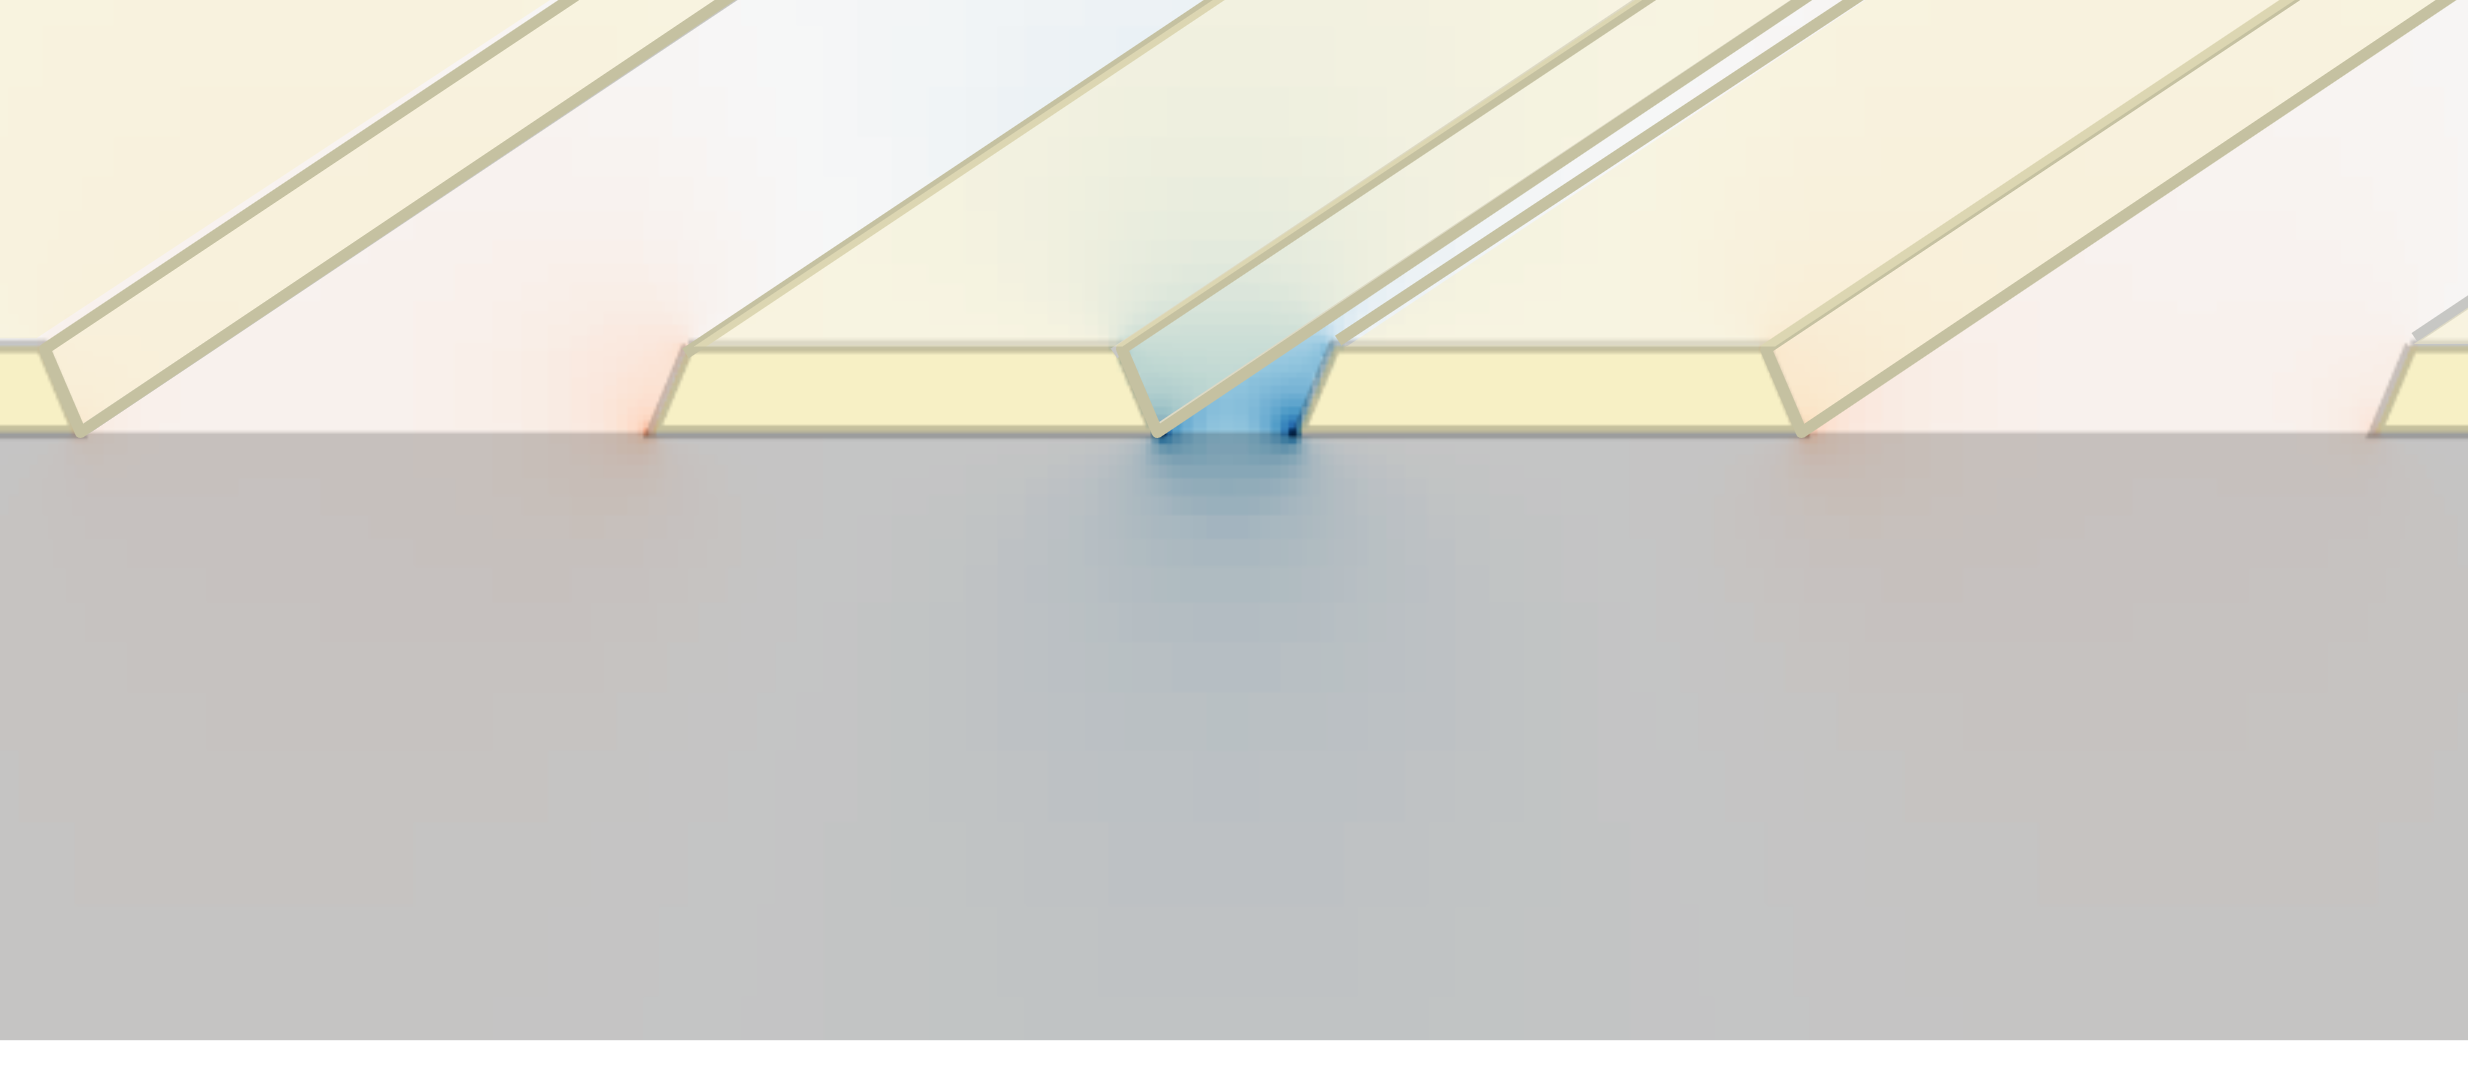


In this notebook, we simulate and analyze a **differential coplanar waveguide (CPW)** structure using both **mode solving** and **time-domain FDTD** methods within PhotonForge.

Our goal is to extract key transmission line properties—**impedance**, **effective index**, and **loss**—for a differential pair over a wide frequency range. We benchmark the results against a reference simulation from another commercial software to validate accuracy.

We start by defining the physical dimensions and material parameters of the CPW layout. All values are selected to match a reference example. The impedance results are compared across varying signal-to-signal spacings to demonstrate consistency with expected differential behavior.

Later in the notebook, we simulate a 1 cm differential CPW line using both FDTD and a Waveguide-based model, and compare their scattering parameters to verify agreement.



In [1]:
import numpy as np
import photonforge as pf
import tidy3d as td
from matplotlib import pyplot as plt
from tidy3d.plugins.dispersion import FastDispersionFitter

td.config.logging_level = "ERROR"
pf.config.default_mesh_refinement = 30  # Set default mesh refinement

## Parameters for Differential CPW Geometry

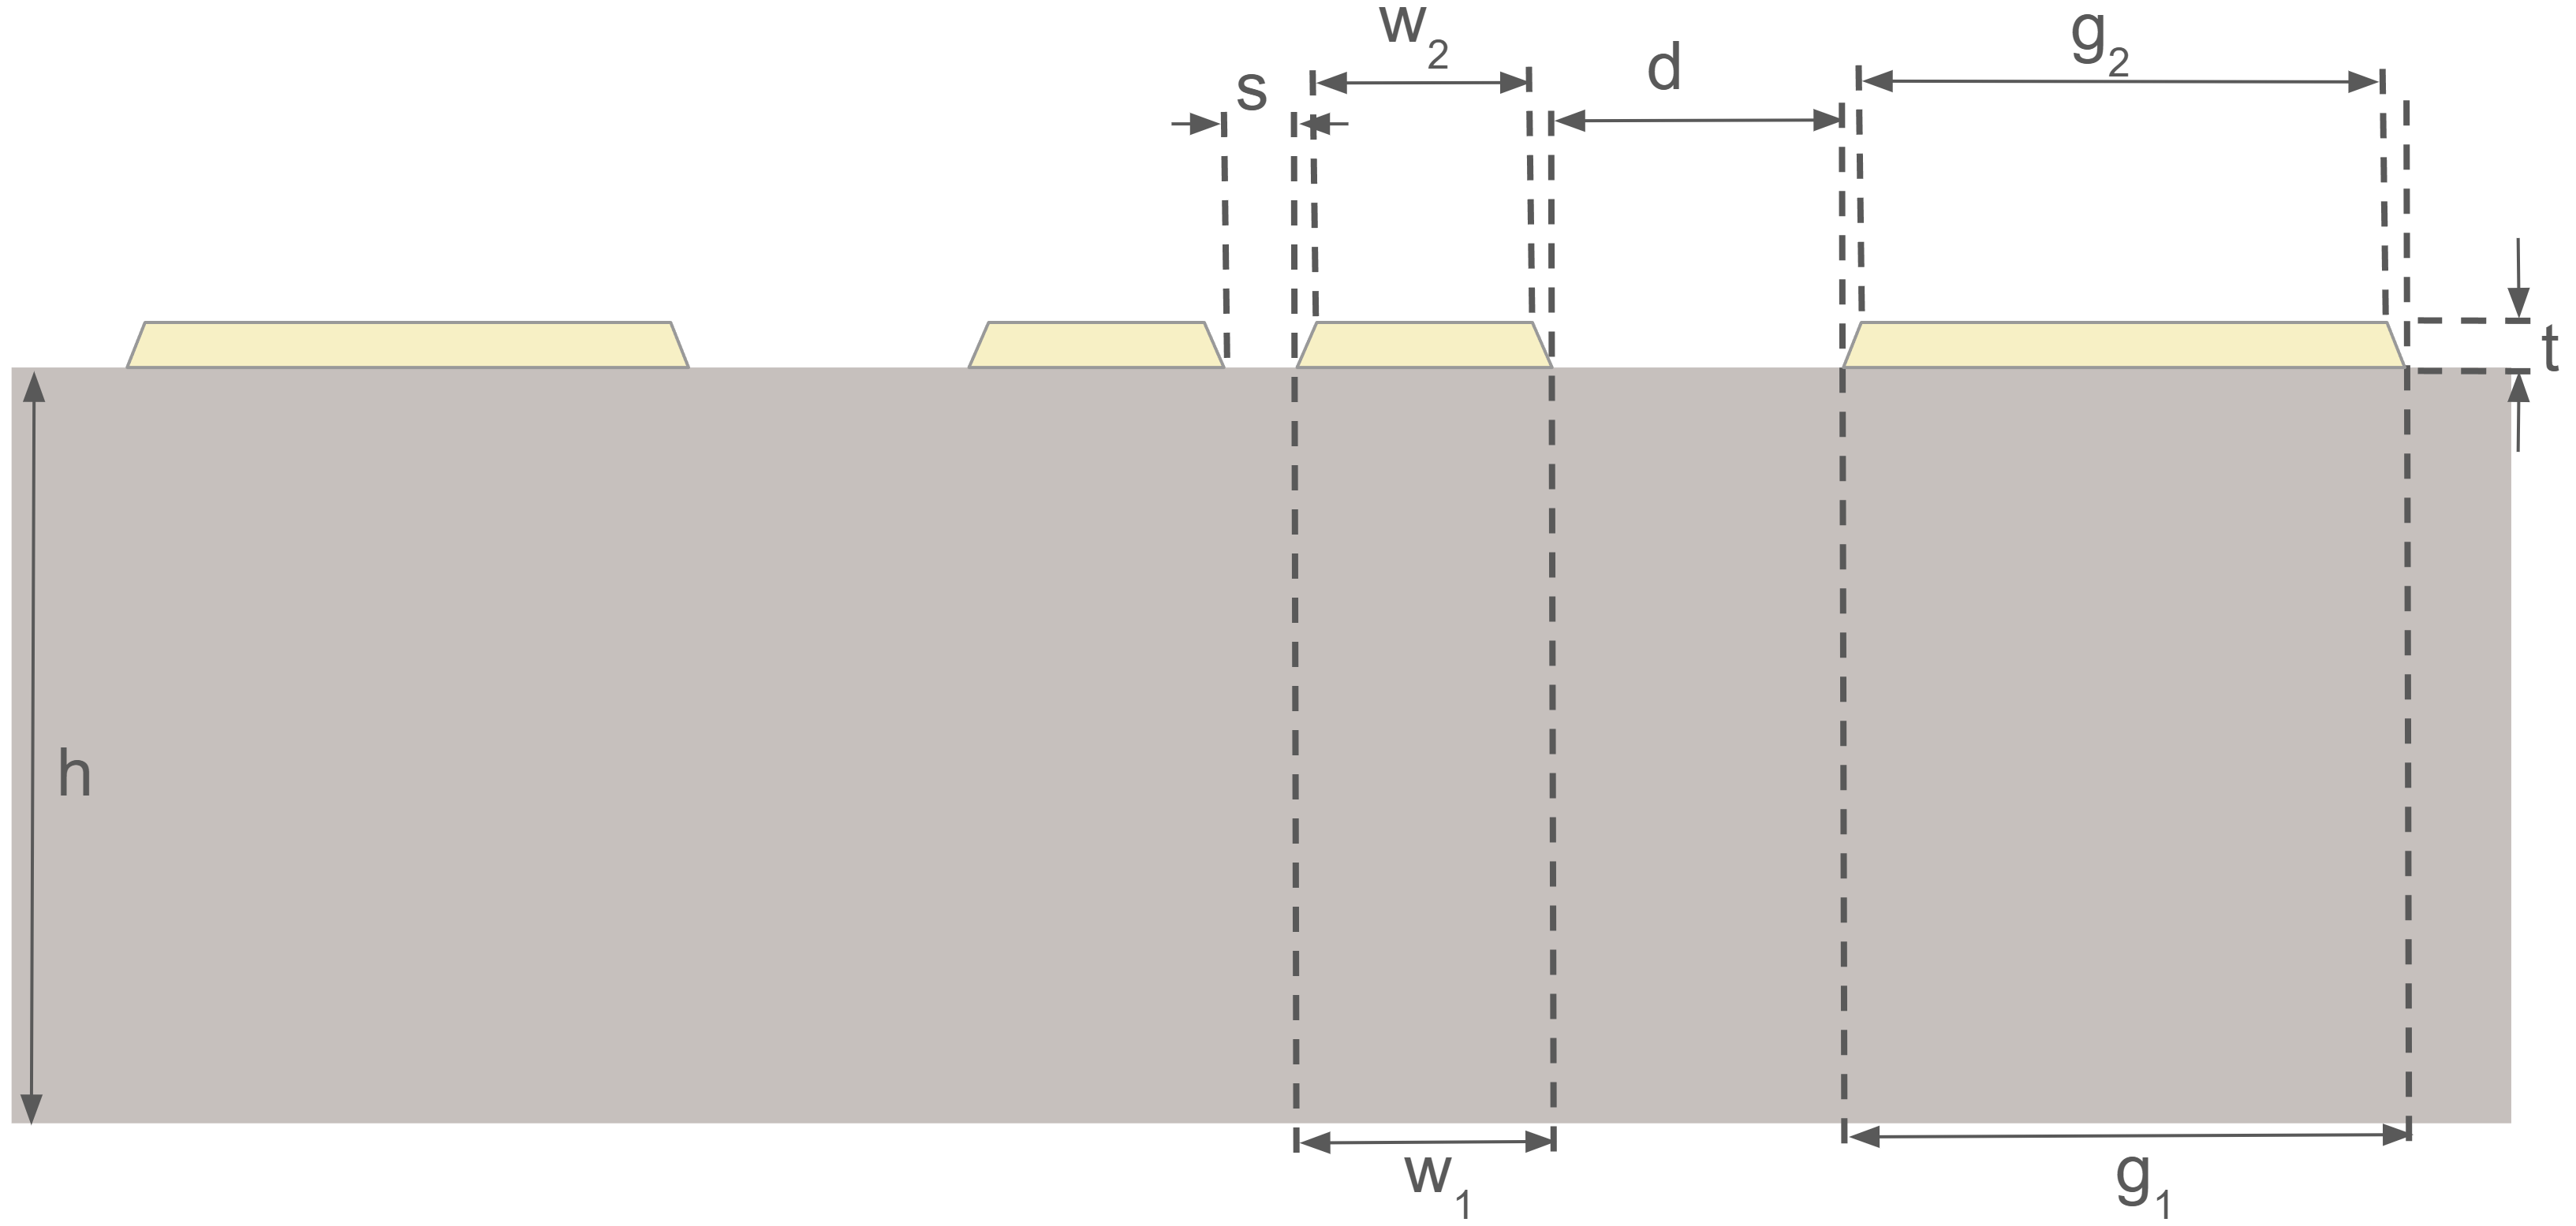

In this section, we define the physical and electrical parameters of the differential coplanar waveguide (CPW) structure based on the diagram provided above. We set the conductor and substrate properties, geometry dimensions, and simulation frequency range. The units are converted using the `mil` factor (1 mil = 25.4 microns), which is commonly used in PCB and microwave engineering. 


In [2]:
f_min = 1e9  # minimum frequency (Hz)
f_max = 50e9  # maximum frequency (Hz)
mil = 25.4  # conversion factor: 1 mil = 25.4 microns

losstan_sub = 0.015  # substrate loss tangent
cond_metal = 41  # metal conductivity
eps_sub = 4.2  # relative permittivity of substrate

h = 8.5 * mil  # substrate thickness
w1 = 7 * mil  # signal width (bottom)
w2 = 6 * mil  # signal width (top)
s = 2 * mil  # spacing between signal lines
g1 = 101 * mil  # ground width (bottom)
g2 = 100 * mil  # ground width (top)
d = 8 * mil  # gap between signal and ground
t = 1.2 * mil  # conductor thickness

freqs = np.linspace(f_min, f_max, 21)  # frequency sweep points

## Simple PCB Technology

We define a reusable `Technology` class that represents a simple PCB stack for our differential CPW. This includes the substrate and transmission line (TL) metal layers. The function allows us to customize key physical properties such as conductor thickness, substrate thickness, and sidewall angle. The stack-up also specifies materials used for the substrate, metal, and surrounding dielectric opening. This technology will be passed to layout and simulation components later.


In [3]:
_Medium = td.components.medium.MediumType  # type alias for medium input


def basic_pcb_tech(
    *,
    sidewall_angle: float = 22.6,  # sidewall taper angle (deg)
    sub_thickness: float = 8.5 * mil,  # substrate thickness (microns)
    tl_thickness: float = 1.2 * mil,  # conductor thickness (microns)
    substrate: _Medium = td.Medium(
        permittivity=4.2, name="Substrate"
    ),  # substrate material
    tl_metal: _Medium = td.PECMedium(),  # metal for transmission lines
    opening: _Medium = td.Medium(
        permittivity=1.0, name="Opening"
    ),  # surrounding dielectric
) -> pf.Technology:
    # Layers
    layers = {
        "TL": pf.LayerSpec(
            layer=(21, 0),  # GDS layer for metal
            description="Metal transmission lines",
            color="#eadb0718",
            pattern="\\",
        ),
    }

    # Extrusion specifications
    bounds = pf.MaskSpec()  # empty mask for entire domain
    tl_mask = pf.MaskSpec((21, 0))  # mask for transmission lines
    extrusion_specs = [
        pf.ExtrusionSpec(bounds, substrate, (-sub_thickness, 0)),  # extrude substrate
        pf.ExtrusionSpec(
            tl_mask, tl_metal, (0, tl_thickness), sidewall_angle
        ),  # extrude TLs
    ]

    # Create and return PCB technology stack
    technology = pf.Technology("PCB", "0", layers, extrusion_specs, {}, opening)

    return technology


We compute the effective sidewall angle based on the difference between ground and signal widths, assuming symmetric metal tapering. This angle is then used to instantiate our PCB technology stack. Finally, we set this technology as the default in PhotonForge for use in subsequent component definitions and simulations.


In [4]:
# compute metal sidewall angle in degrees
sidewall_angle = np.degrees(np.arctan((w1 - w2) / 2 / t))

# instantiate PCB tech
tech = basic_pcb_tech(sidewall_angle=sidewall_angle, sub_thickness=h)
pf.config.default_technology = tech  # set as default technology

## Port Definition

We define a `PortSpec` object for the differential CPW using the smallest signal spacing value. This specification includes metal trace profiles as well as paths used to compute voltage and current integrals for impedance extraction. 

To better understand the setup, we visualize the port cross-section at the simulation center and overlay the **voltage** and **current integration paths**. This helps confirm that the field sampling and excitation definitions are aligned with the geometry and symmetry of the structure.

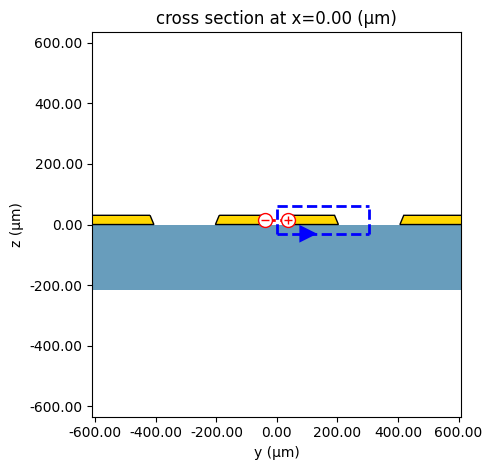

In [5]:
dcpw_spec = pf.PortSpec(
    description="Differential CPW transmission line",
    width=2 * g1 + s + 2 * w1 + 2 * d - 1 * mil,  # simulation domain width
    limits=(-100 * mil, 100 * mil),  # z-axis extent
    num_modes=1,  # number of target modes
    added_solver_modes=0,  # extra solver modes
    polarization="",  # default polarization
    target_neff=2,  # expected effective index
    path_profiles={  # cross-sectional layout
        "gnd0": (g2, w1 + d + (s + g1) / 2, (21, 0)),
        "gnd1": (g2, -(w1 + d + (s + g1) / 2), (21, 0)),
        "signal0": (w2, -(s + w1) / 2, (21, 0)),
        "signal1": (w2, (s + w1) / 2, (21, 0)),
    },
    voltage_path=[  # voltage integration line
        (-s / 2 - (w1 - w2) / 2, t / 2),
        (s / 2 + (w1 - w2) / 2, t / 2),
    ],
    current_path=[  # current integration loop
        (w1 + s / 2 + d / 2, 2 * t),
        (0, 2 * t),
        (0, -t),
        (w1 + s / 2 + d / 2, -t),
    ],
)

ax = pf.tidy3d_plot(dcpw_spec, frequency=freqs[0])  # plot port geometry
ic = dcpw_spec.to_tidy3d_impedance_calculator()  # create impedance calculator

_ = ic.voltage_integral.plot(ax=ax, x=0)  # overlay voltage path
_ = ic.current_integral.plot(ax=ax, x=0)  # overlay current loop

ax.set_xlim((-(s / 2 + w1 + 2 * d), (s / 2 + w1 + 2 * d)))  # limit x view
ax.set_ylim((-25 * mil, 25 * mil))  # limit y view
plt.show()

### Inspect Ey Field to Verify Differential Mode

To extract the correct differential impedance, we first visualize the electric field distribution for the computed mode. We verify the **odd-symmetry voltage mode** (i.e., the differential mode) by inspecting the `Ey` component of the fields.

We apply **mirror symmetry** to the simulation domain to ensure that the computed field profiles respect the physical symmetry of the differential structure. This not only reduces simulation size but also significantly improves the accuracy of impedance extraction.


Loading cached simulation from .tidy3d/pf_cache/IWT/ms_info-4SW7M5H7H4RTYU4ZJZ5TB4JIGBQ75KK64V4ZOXGRWQKYCHLDBUSA.json.


Progress: 100%


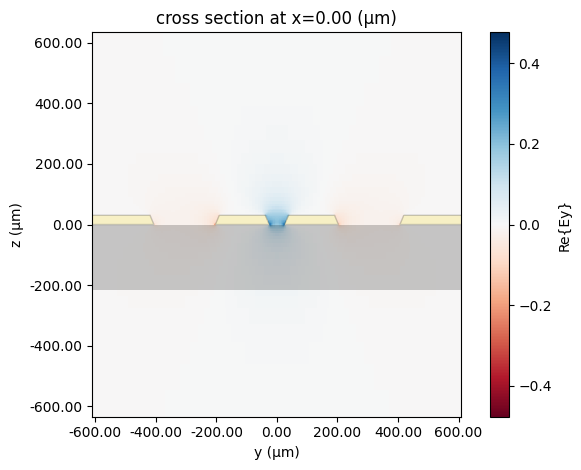

In [6]:
cpw_solver = dcpw_spec.to_tidy3d(freqs)  # solve for port modes
cpw_solver_sym = cpw_solver.updated_copy(
    simulation=cpw_solver.simulation.updated_copy(
        symmetry=(0, -1, 0),  # apply y-symmetry
    )
)
mode_data = pf.port_modes(cpw_solver_sym)  # extract mode field data
ax = mode_data.plot_field("Ey", "real", f=freqs[0], robust=False)
ax.set_xlim((-(s / 2 + w1 + 2 * d), (s / 2 + w1 + 2 * d)))  # x-range
ax.set_ylim((-25 * mil, 25 * mil))  # y-range
plt.show()

### Extract Impedance and Effective Index

After computing the differential mode, we extract its physical characteristics across the frequency range. These include:

- The **real part of the differential impedance** `Z₀`,
- The **effective refractive index** `n_eff`, and


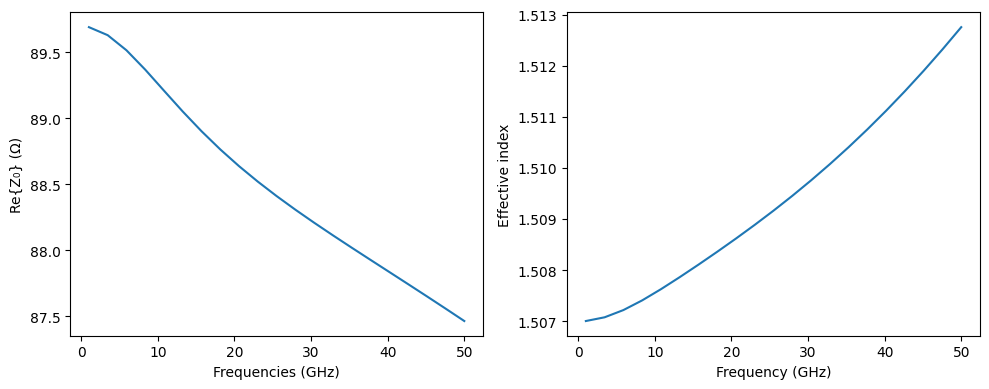

In [7]:
# differential impedance
z0 = ic.compute_impedance(mode_data.data).real

n_eff = mode_data.data.n_eff  # effective index

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

ax[0].plot(z0.f * 1e-9, z0)  # plot impedance vs frequency
ax[0].set(xlabel="Frequencies (GHz)", ylabel="Re{Z₀} (Ω)")

ax[1].plot(freqs / 1e9, n_eff)  # plot effective index
ax[1].set_xlabel("Frequency (GHz)")
ax[1].set_ylabel("Effective index")

plt.show()

### Benchmark Simulated Impedance Against Reference Data

In this section, we verify the simulated differential impedance of the CPW structure by comparing it with a reference simulation from another commercial software. We sweep the signal-to-ground spacing `s` and extract the real part of the differential impedance at the fundamental mode.

Here, we present an alternative approach for computing the impedance **without enforcing symmetry** directly in the simulation setup. In this case, small numerical asymmetries in the computed field profiles can cause slight differences in the calculated currents on the two signal traces. To account for this, we compute the impedance twice—once for each current path mirrored across the centerline—and then combine the results by summing their reciprocals. This method aligns with the definition of differential impedance, which is inversely proportional to the total current. The second call to `pf.port_modes` reuses the cached field solution and only recalculates the impedance, adding negligible overhead to the total simulation time.

It's also important to note that the **differential impedance** `Z₀(diff)` is equal to **twice the odd-mode impedance** `Z₀(odd)` of a single-ended structure. As the spacing `s` increases, coupling between the signal lines decreases, and `Z₀(diff)` asymptotically approaches twice the single-ended value. In our case, the impedance saturates around 228 Ω, which aligns well with the expected 112 Ω of an isolated single-ended CPW line with the same geometry.


Loading cached simulation from .tidy3d/pf_cache/IPQ/ms_info-FFAUIQUCBH3GAQEUQAAISV24CJV5KFHZRFOIL6HC2IWS7HOQZWMA.json.


Progress: 100%


Progress: 100%


Loading cached simulation from .tidy3d/pf_cache/KQS/ms_info-OBWJWN4LKUFAPAIKCE5QNVRFOMES7ZPR52LPLNJNXSXGIHUX22YQ.json.


Progress: 100%


Progress: 100%


Loading cached simulation from .tidy3d/pf_cache/WUB/ms_info-KTIFM7QEW75M5LCKRW3URCGXOKZEPDA56Q5B4WEMUJR3GTC6KW4Q.json.


Progress: 100%


Progress: 100%


Loading cached simulation from .tidy3d/pf_cache/GRQ/ms_info-5JMMRU7UE5SPG324B4NW44BYPIFAGPLRL7SXZKWEVTIER5TC3NAQ.json.


Progress: 100%


Progress: 100%


Loading cached simulation from .tidy3d/pf_cache/OQD/ms_info-D7XYONGBNDPWW3P62NKHNKLHXDLVOQSKE5FJJWB4IQZ4C2PMS3OA.json.


Progress: 100%


Progress: 100%


Loading cached simulation from .tidy3d/pf_cache/KW5/ms_info-CFKGJQXSSKZKF6FR4M4SIILIL6CZMQLQXJHHVPKWDFYZPGYOC2NA.json.


Progress: 100%


Progress: 100%


Loading cached simulation from .tidy3d/pf_cache/IUU/ms_info-UENEOBSLA74KV3FUXRQP3QVBL33QVWS5ONR6M36V4EAWJWU7WQMA.json.


Progress: 100%


Progress: 100%


Loading cached simulation from .tidy3d/pf_cache/745/ms_info-VV2I2LPPZZT5SYDKLM2NIZUQG3IJYN2OKFJWDUMGENT2CGAH7GGQ.json.


Progress: 100%


Progress: 100%


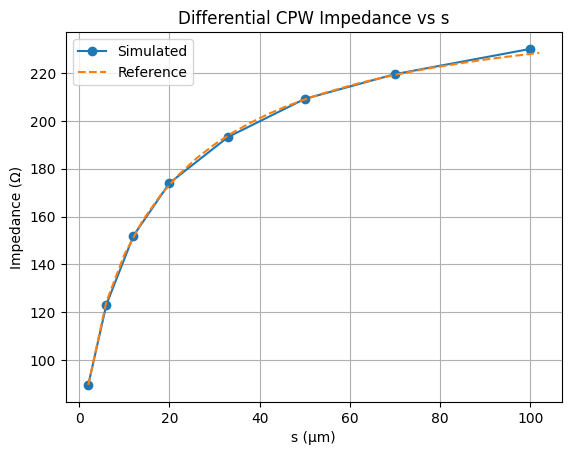

In [8]:
s_values = np.array([2, 6, 12, 20, 33, 50, 70, 100]) * mil  # sweep values for gap s
z0_real_values = []  # store real parts of simulated impedance

for s in s_values:
    spec = pf.PortSpec(
        description="Differential CPW transmission line",
        width=2 * g1 + s + 2 * w1 + 2 * d - 1 * mil,  # simulation domain width
        limits=(-100 * mil, 100 * mil),  # z-axis extent
        num_modes=1,  # number of target modes
        added_solver_modes=0,  # extra solver modes
        polarization="",  # default polarization
        target_neff=2,  # expected effective index
        path_profiles={  # cross-sectional layout
            "gnd0": (g2, w1 + d + (s + g1) / 2, (21, 0)),
            "gnd1": (g2, -(w1 + d + (s + g1) / 2), (21, 0)),
            "signal0": (w2, -(s + w1) / 2, (21, 0)),
            "signal1": (w2, (s + w1) / 2, (21, 0)),
        },
        voltage_path=[  # differential voltage path
            (-s / 2 - (w1 - w2) / 2, t / 2),
            (s / 2 + (w1 - w2) / 2, t / 2),
        ],
        current_path=[  # differential current loop
            (w1 + s / 2 + d / 2, 2 * t),
            (0, 2 * t),
            (0, -t),
            (w1 + s / 2 + d / 2, -t),
        ],
    )

    _, z0_1 = pf.port_modes(spec, [freqs[0]], impedance=True)
    spec.current_path = [(-x, y) for x, y in spec.current_path]
    _, z0_2 = pf.port_modes(spec, [freqs[0]], impedance=True)
    z0 = 2 / (1 / z0_1 + 1 / z0_2)
    z0_real_values.append(z0.isel(f=0).real.item())


# Reference data from another commercial simulation
data_ref = [
    [2, 89.5],
    [6, 124.3],
    [10, 144.1],
    [14, 158.2],
    [18, 168.9],
    [22, 177.4],
    [26, 184.4],
    [30, 190.2],
    [34, 195.1],
    [38, 199.3],
    [42, 203.0],
    [46, 206.2],
    [50, 209.0],
    [54, 211.5],
    [58, 213.7],
    [62, 215.8],
    [66, 217.6],
    [70, 219.3],
    [74, 220.8],
    [78, 222.2],
    [82, 223.4],
    [86, 224.6],
    [90, 225.7],
    [94, 226.7],
    [98, 227.6],
    [102, 228.5],
]
s_ref = [row[0] for row in data_ref]  # reference s values
z0_ref = [row[1] for row in data_ref]  # reference impedance values

# Plot both
plt.figure()
plt.plot(
    s_values / mil, z0_real_values, marker="o", label="Simulated"
)  # simulation results
plt.plot(s_ref, z0_ref, linestyle="--", label="Reference")  # reference curve
plt.xlabel("s (µm)")
plt.ylabel("Impedance (Ω)")
plt.title("Differential CPW Impedance vs s")
plt.legend()
plt.grid(True)
plt.show()

# Reset s to default vaule
s = 2 * mil

## Lossy Differential CPW

In this section, we aim to simulate a **lossy differential CPW transmission line** by defining frequency-dependent models for both the conductor and the substrate. This allows us to capture realistic attenuation behavior due to dielectric and conductor losses.

We use a surface impedance fitting model for the metal, and a constant-loss-tangent dispersion model for the substrate. These models are valid over the frequency range of interest and will be used in both **FDTD** and **mode solver** simulations. Later, we will compare the results of these two approaches to assess consistency and accuracy.


In [9]:
lossy_metal: _Medium = td.LossyMetalMedium(
    conductivity=cond_metal,  # metal conductivity
    frequency_range=[f_min, f_max],  # fit range for frequency-dependent loss
    fit_param=td.SurfaceImpedanceFitterParam(max_num_poles=16),  # fitting parameters
)

lossy_substrate: _Medium = FastDispersionFitter.constant_loss_tangent_model(
    eps_real=eps_sub,  # real permittivity of substrate
    loss_tangent=losstan_sub,  # loss tangent for lossy dielectric
    frequency_range=(f_min, f_max),  # frequency range of interest
)

tech = basic_pcb_tech(
    sidewall_angle=sidewall_angle,  # sidewall taper angle
    sub_thickness=h,  # substrate thickness
    substrate=lossy_substrate,  # frequency-dependent substrate model
    tl_metal=lossy_metal,  # frequency-dependent metal model
)
pf.config.default_technology = tech  # set lossy tech as default

Output()

### FDTD Simulation

We now simulate a **1 cm long differential CPW line** using FDTD to evaluate its broadband S-parameter response. A field monitor is placed at the center of the line to record cross-sectional fields, which will later be used for mode inspection.

The structure is configured using the same port specification as the mode solver, and we apply mirror symmetry. After activating the model, we extract the full **scattering matrix** over the desired frequency range.


In [10]:
dcpw_length = 10000  # 1 cm line length in microns

field_monitor_yz = td.FieldMonitor(
    center=(dcpw_length / 2, 0, 0),  # center of the transmission line
    size=(0, td.inf, td.inf),  # yz cross-section
    freqs=[20e9],  # monitor frequency
    name="field_yz",  # monitor name
)

dcpw_line = pf.parametric.straight(  # create straight DCPW line
    port_spec=dcpw_spec,
    length=dcpw_length,
    name="DCPW Line",
    tidy3d_model_kwargs={
        "symmetry": (0, -1, 0),  # apply symmetry
        "monitors": [field_monitor_yz],  # add field monitor
    },
)

dcpw_line.activate_model("Tidy3D")  # activate FDTD model
s_matrix = dcpw_line.s_matrix(frequencies=freqs)  # simulate and extract S-parameters

# pf.tidy3d_plot(dcpw_line, z=t / 2, hlim=(-500, 10100), vlim=(-2000, 2000))
pf.tidy3d_plot(dcpw_line, plot_type='3d')

Loading cached simulation from .tidy3d/pf_cache/IL3/fdtd_info-DBS73ZKZMQDOSG7MN3TGZ3VILUOACAR2PQX2R657455CM44Z2QVA.json.


Loading cached simulation from .tidy3d/pf_cache/IL3/ms_info-SIAHHYYF6HHJ54VFVPUXCW4BATHJMU37Q2SU3OK5AYKVPLMLIZFA.json.
Loading cached simulation from .tidy3d/pf_cache/IL3/ms_info-M5J65ZGW3OB3DPYEPSQ4Q6KJQ2KXIEKL3MLD6EVEDDX4IQPT2MQA.json.
Progress: 100% 


### Simulate S-Matrix Using Waveguide Model

We now switch from full-wave FDTD simulation to the **Waveguide model**, which reconstructs the transmission behavior using modal propagation constants such as effective index and loss. This model provides an efficient alternative for long uniform structures.

By activating the Waveguide model for our 1 cm differential CPW line, we compute the corresponding S-matrix across the frequency sweep. The result can be directly compared to the FDTD simulation for validation.


In [11]:
# activate Waveguide model
dcpw_line.activate_model("Waveguide")

# simulate and extract S-parameters
s_matrix_mode = dcpw_line.s_matrix(frequencies=freqs)

Loading cached simulation from .tidy3d/pf_cache/XFA/ms_info-3RSJXBO4MK2YY2SHAI2EEM2IBZV3QC67CFJF5DAJ7G2FX76FUPPQ.json.
Progress: 100% 


### Compare 3D FDTD RF Model and Waveguide Model

We finalize the comparison by plotting the transmission response of the differential CPW line obtained from both our GPU-accelerated **RF FDTD solver** and the **Waveguide model** (RF mode solver). 

We plot the **magnitude** and **phase** of `S21` for both approaches. Good agreement confirms the validity of using the Waveguide model as an efficient surrogate for full-wave simulations when the geometry is uniform and dispersion is captured accurately.


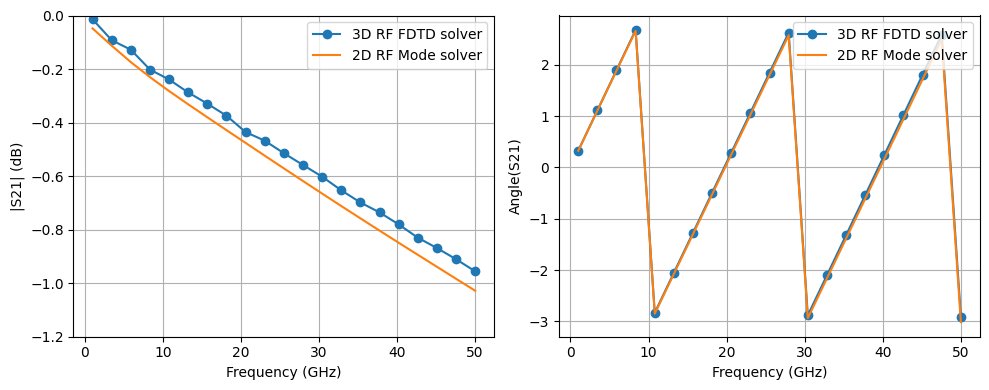

In [12]:
# Extract S-parameters
s21 = s_matrix["E0@0", "E1@0"]  # FDTD result
s21_mode = s_matrix_mode["E0@0", "E1@0"]  # Waveguide model result

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Plot |S21| in dB
ax[0].plot(freqs / 1e9, 20 * np.log10(np.abs(s21)), marker="o", label="3D RF FDTD solver")
ax[0].plot(freqs / 1e9, 20 * np.log10(np.abs(s21_mode)), label="2D RF Mode solver")
ax[0].set_xlabel("Frequency (GHz)")
ax[0].set_ylabel("|S21| (dB)")
ax[0].set_ylim((-1.2, 0))
ax[0].grid(True)
ax[0].legend()

# Plot phase of S21
ax[1].plot(freqs / 1e9, np.angle(s21), marker="o", label="3D RF FDTD solver")
ax[1].plot(freqs / 1e9, np.angle(s21_mode), label="2D RF Mode solver")
ax[1].set_xlabel("Frequency (GHz)")
ax[1].set_ylabel("Angle(S21)")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


We could also directly use the `port_modes` data to extract loss.



Progress: 100%


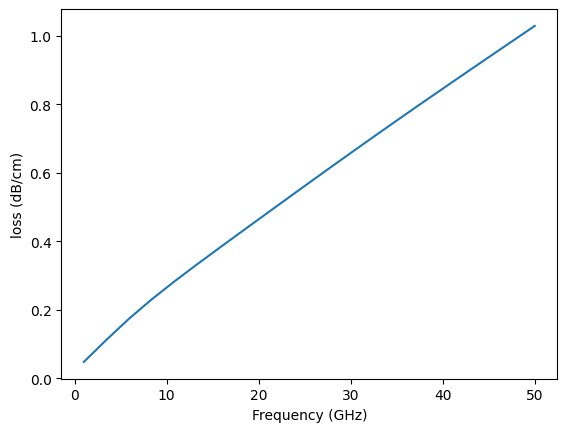

In [13]:
mode_data = pf.port_modes(dcpw_spec, freqs)
# loss in dB/cm
alpha = mode_data.data.modes_info["loss (dB/cm)"]

plt.plot(freqs / 1e9, alpha)  # plot loss in dB/cm
plt.xlabel("Frequency (GHz)")
plt.ylabel("loss (dB/cm)")
plt.show()